In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
seed = 1
batch_size = 128
epochs = 10
log_interval = 10

In [3]:
HAVE_CUDA=True

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if HAVE_CUDA else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


In [22]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 1 inp channel, 10 output channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 
        self.conv2_drop = nn.Dropout2d() 

        
        self.fc1 = nn.Linear(320, 100)
        self.fc21 = nn.Linear(100, 20)
        self.fc22 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 100)
        self.fc4 = nn.Linear(100, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
          std = logvar.mul(0.5).exp_()
          eps = Variable(std.data.new(std.size()).normal_())
          return eps.mul(std).add_(mu)
        else:
          return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        mu, logvar = self.encode(x.view(-1, 320))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [23]:
model = VAE()
if HAVE_CUDA:
    model.cuda()


In [24]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_size * 784

    return BCE + KLD


In [25]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [37]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if HAVE_CUDA:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> TRAIN Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    loss_val =  train_loss/len(train_loader.dataset)
    return loss_val

In [38]:
def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        if HAVE_CUDA:
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
          n = min(data.size(0), 8)
          comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [45]:
losses = []
for epoch in range(1, 1 + 10):
    train_loss = train(epoch)
    print('train_loss', train_loss)
    losses.append(train_loss)
    test(epoch)
    sample = Variable(torch.randn(64, 20))
    if HAVE_CUDA:
       sample = sample.cuda()
    sample = model.decode(sample).cpu()
    save_image(sample.data.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001237
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.001205
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.001158
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.001194
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.001206
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.001176
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.001178
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.001159
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.001182
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.001208
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001187
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.001178
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.001184
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.001171
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.001159
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001172
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.001152
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.001161
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.001210
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.001152
Train Epoch: 1 [

Train Epoch: 4 [24320/60000 (41%)]	Loss: 0.001097
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.001151
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.001132
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.001171
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.001161
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.001134
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001090
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.001102
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.001103
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.001094
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.001126
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.001097
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.001142
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.001129
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.001095
Train Epoch: 4 [43520/60000 (72%)]	Loss: 0.001113
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.001101
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.001109
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.001144
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.001159


Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.001120
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.001155
Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.001144
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.001131
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.001144
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.001078
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.001128
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.001123
====> TRAIN Epoch: 7 Average loss: 0.0011
train_loss 0.0011154718955357868
====> Test set loss: 0.0010
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.001086
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.001153
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.001110
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.001100
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.001151
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.001077
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.001103
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.001054
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.001151
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.001086
Train Epoch: 

In [43]:
import matplotlib.pyplot as plt

In [46]:
print(losses)

[0.0011664077001313368, 0.0011523313182095686, 0.0011423587044080098, 0.0011337520415584247, 0.0011272411088148753, 0.0011210897276798884, 0.0011154718955357868, 0.0011118265862266224, 0.0011078688845038414, 0.0011049945468703905]


In [47]:
plt.plot(losses)

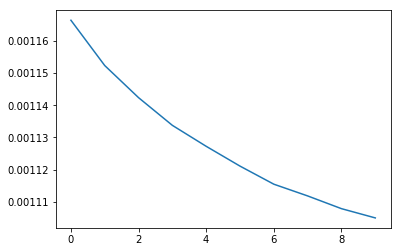

In [48]:
plt.show()